# Modelo Aturregresivo (AR)

Se importan las librerias.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Se obtienen los datos limpios de 2015 y 2016.

In [2]:
df2015 = pd.read_csv('./drive/MyDrive/DatosInvestigacion/2015_2016_dataset.csv', index_col=0, parse_dates=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Se establece la frecuencia del dataset en horas. Esto es para evitar ciertos warning en el uso de este modelo.

In [3]:
df2015 = df2015.asfreq('h')

Se obtiene la variable que se quiere predecir entre las horas de más información.

In [4]:
df = pd.DataFrame()
df['RSG'] = df2015['SRGLOAVG1H'].between_time('08:00:00','17:00:00')

## Definición
El modelo AR más simple, de 1 retraso, se define de la siguiente forma:

$x_{t}=c+ϕ_{1} x_{t-1}+ϵ_{t}$


Donde $x_{t}$ es el valor que se quiere predecir, $x_{t-1}$ es el valor de la variable en el tiempo anterior, $c$ es una constante y $ϵ_{t}$ es el residuo entre la predicción y el valor real.

Se mantiene la siguiente limitación para el coeficiente que multiplica el valor anterior $x_{t-1}$

$| ϕ_{1} | < 1$

## Implementación

Se importa el modelo ARMA.

In [ ]:
from statsmodels.tsa.arima_model import ARMA

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Se utilizará 1 retraso, el otro parámetro dentro de `order` se mantiene en 0 para que sea un modelo AR y no ARMA.

In [ ]:
model_ar = ARMA(df['RSG'], order=(1,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Se entrena el modelo con los datos de radiación solar.

In [ ]:
results_ar = model_ar.fit()

Se observa un resumen de los resultados obtenidos por el entrenamiento.

In [ ]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    RSG   No. Observations:                 7310
Model:                     ARMA(1, 0)   Log Likelihood              -48393.161
Method:                       css-mle   S.D. of innovations            181.481
Date:                Thu, 27 Jan 2022   AIC                          96792.322
Time:                        18:53:09   BIC                          96813.013
Sample:                             0   HQIC                         96799.436
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        414.7514      6.844     60.604      0.000     401.338     428.165
ar.L1.RSG      0.6899      0.008     81.486      0.000       0.673       0.707
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4494           +0.0000j            1.4494            0.0000
-----------------------------------------------------------------------------
"""

En la tabla existe un p-valor `P` que sirve para decidir si un coeficiente es útil dentro de la ecuación AR.

La hipótesis nula es que el coeficiente es igual a 0. Ya que el p-valor de los coeficientes observados en el resumen es igual a cero, el valor de estos es significativo. Es decir, se puede utilizar el modelo AR con un retraso.

## Búsqueda de la mejor cantidad de retrasos

Se importa una librería para que realice la búsqueda del mejor número de retrasos.

In [ ]:
from statsmodels.tsa.ar_model import AR

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Se divide en datos de entrenamiento y prueba, el 80% de los datos se utilizarán para entrenamiento.

In [13]:
train_size = int(len(df)*0.8)

In [14]:
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

Se utilizarán 5848 datos para el entrenamiento.

In [ ]:
len(df_train)

5848

Se importa una librería para que no aparezcan warnings durante el entrenamiento.

In [ ]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

Se ejecuta el modelo con los datos de radiación solar y se coloca un máximo de retrasos, en este caso el número 24 representa más de dos días hacia el pasado, pues sólo se toman en cuanta los datos del día.

In [ ]:
model = AR(df_train['RSG'])
ARfit = model.fit(maxlag=24,ic='bic') 
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 22
Coefficients:
const      88.465247
L1.RSG      0.635393
L2.RSG     -0.103026
L3.RSG      0.043116
L4.RSG     -0.032294
L5.RSG     -0.004597
L6.RSG     -0.002247
L7.RSG     -0.010747
L8.RSG      0.021191
L9.RSG      0.111859
L10.RSG     0.140868
L11.RSG     0.000666
L12.RSG    -0.033811
L13.RSG    -0.006970
L14.RSG    -0.041583
L15.RSG    -0.016905
L16.RSG    -0.012530
L17.RSG     0.000388
L18.RSG     0.007379
L19.RSG     0.072742
L20.RSG     0.063291
L21.RSG     0.011766
L22.RSG    -0.066640
dtype: float64


El mejor modelo considera 22 retrasos, es decir dos días y dos horas hacia el pasado. Este valor se utilizará como referencia para los modelos LSTM.

### Evaluación del modelo

Se utilizará el Mean Square Error (MSE) como referencia.


In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Es necesario reproducir la ecuación utilizando los coeficientes.

In [ ]:
coef = ARfit.params

In [ ]:
coef[0]

88.46524724190891

Esta función permite calcular las predicciones con nuevos valores, servirá para aplicar el modelo sobre los datos de test.

In [7]:
def get_pred(coef,data):
  prediction = coef[0] # constante
  # los datos se reciben en forma cronológica
  j = 1
  for i in range(len(data)-1,-1,-1):
    prediction += coef[j] * data[i]
    j+=1
  return prediction


Se usan los últimos datos del conjunto de entrenamiento.

In [ ]:
get_pred(coef,df_train[-22:].values)

array([269.947196])

Se puede observar que se obtiene el mismo resultado con la función `predict` del modelo, sin embargo, es imposible seguir avanzando en los datos de prueba con la función predict. Por eso, la implementación `get_pred` es utilizará con en el testing.

In [ ]:
ARfit.predict(start=len(df_train),end=len(df_train)+1)

5848    269.946018
5849    189.341642
dtype: float64

El valor real es mayor al valor predicho.

In [ ]:
df_test.iloc[0].values

array([334.])

Se va a recorrer todo el dataset de prueba para evaluar al modelo.

In [ ]:
test_pred = []

In [ ]:
retrasos = 22

Se consiguen predicciones de todo el conjunto de prueba, excepto los 22 primeros registros que se usan para comenzar.

In [ ]:
for i in range(retrasos,len(df_test)):
  past_data = df_test.iloc[i-retrasos:i].values
  test_pred.append(get_pred(coef,past_data))

Se aplana el vector de resultados para utilizarlo más fácilmente.

In [ ]:
test_pred = np.ndarray.flatten(np.array(test_pred))

Se puede ver que el tamaño de las prediccions es menor al del conjunto de prueba debido a esas primeras 22 horas.

In [ ]:
test_pred.shape

(1440,)

In [ ]:
df_test.shape

(1462, 1)

Se eliminan las primeras 22 horas del conjunto de pruebas.

In [ ]:
real_data = df_test.iloc[retrasos:].values

In [ ]:
real_data = np.ndarray.flatten(np.array(real_data))

Ahora la longitud es la misma que el conjunto de predicciones.

In [ ]:
len(real_data)

1440

Se calcula el error RMSE del modelo.

In [ ]:
errorAR = mean_squared_error(real_data,test_pred)
errorAR

28497.23241249754

Hay que recordar que las unidades de medida de esta variable son $\frac{W}{m^2}$

In [ ]:
np.sqrt(errorAR)

168.81123307557925

Se grafican los resultados.

In [ ]:
plot_df = pd.DataFrame()
plot_df['real_value'] = df_test['RSG'][retrasos:]
plot_df['prediction'] = test_pred

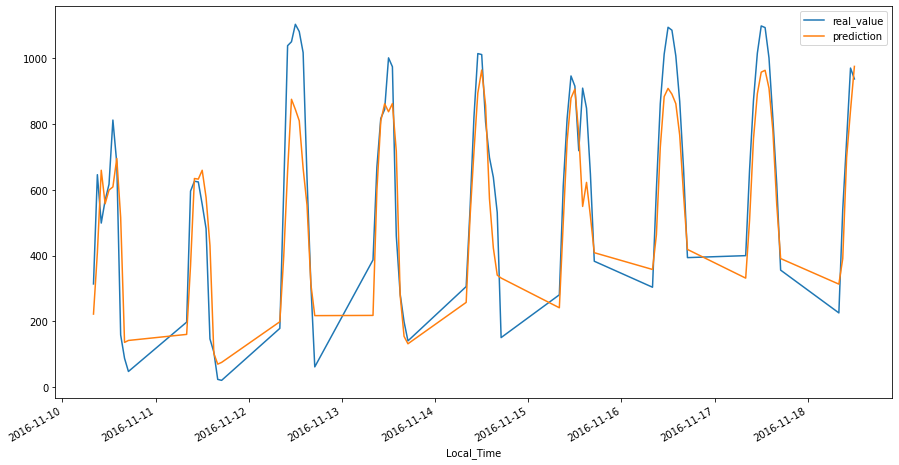

In [ ]:
plot_df[:]['2016-11-10 7:00:00':'2016-11-18 12:00:00'].plot(figsize=(15,8))

### Evaluar ventana de tiempo hacia el futuro

Se declara una lista con los coeficientes para poder usarla en cualquier ocasión.

In [8]:
coef = [88.465247,
                0.635393,-0.103026,0.043116,-0.032294,
                -0.004597,-0.002247,-0.010747,0.021191,
                0.111859,0.140868,0.000666,-0.033811,
                -0.006970,-0.041583,-0.016905,-0.012530,
                0.000388,0.007379,0.072742,0.063291,0.011766,
                -0.066640]

El objetivo es ver cómo crece el error al incrementar la ventana de predicción.

In [17]:
retrasos=22
resultados = []

In [ ]:
for ventana in range(1,33):
  predictions = []
  true_values = []
  print(ventana)
  for j in range(retrasos,len(df_test)-ventana):
    past_data = df_test.iloc[j-retrasos:j].values
    for i in range(ventana):
        current_pred = get_pred(coef,past_data)
        predictions.append(current_pred) 
        past_data = np.append(past_data[1:,:],[current_pred],axis=0)
        true_values.append(df_test.iloc[j+i])

  true_predictions = np.ndarray.flatten(np.array(predictions))
  errorMSE = mean_squared_error(true_values,true_predictions)
  errorMAE = mean_absolute_error(true_values,true_predictions)  
  resultados.append({
      'Ventana':ventana,
      'MAE':errorMAE,
      'RMSE':np.sqrt(errorMSE)
  })
  print(resultados[-1])

In [21]:
resultados = pd.DataFrame(resultados)

In [26]:
resultados.tail()

,Ventana,MAE,RMSE
27,28,187.481929,234.525399
28,29,187.948620,235.045506
29,30,188.404314,235.559316
30,31,188.921206,236.159206
31,32,189.516661,236.851506


Se grafica el error a medida que crece la ventana de predicción. Llega hasta un error RMSE de 236.85 cuando se predicen 32 horas.

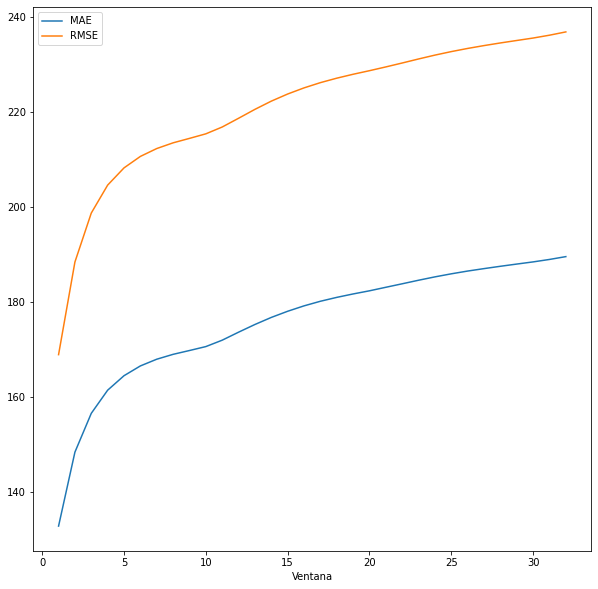

In [22]:
resultados.plot(x='Ventana',figsize=(10,10))

In [24]:
resultados.to_csv('./drive/MyDrive/DatosInvestigacion/resultados_prediccion_AR.csv',index=False)

## Guardado de datasets

Los datasets para entrenamiento y prueba se almacenarán en archivos diferentes.

In [ ]:
df_simple = df2015[['SRGLOAVG1H','TAMAX1H','TAMIN1H','RHMAX1H','RHMIN1H','PRSUM1H','PAAVG1H','PAMAX1H','PAMIN1H','WS1HA','WS1HX','WD1HA']]

In [ ]:
train_size = int(len(df_simple)*0.8)

In [ ]:
train_size

14035

In [ ]:
df_train = df_simple.iloc[:train_size]
df_test = df_simple.iloc[train_size:]

In [ ]:
df_train.to_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv')
df_test.to_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv')